# lgbm model
sample of lgbm model and show how to use evaluate model function.  
this baseline model.  
local validation score is 0.3457213198021423.  

# import modules

In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from lib.preprocess import Preprocess
from sklearn.manifold import TSNE
from sklearn.utils import compute_sample_weight
import shap

/home/nakagawaren/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# load data

In [2]:
SEED = 314
datasrc = "data/official/"
data = pd.read_csv(os.path.join(datasrc, "train.csv"), index_col=0)
x_test = pd.read_csv(os.path.join(datasrc, "test.csv"), index_col=0)

train, valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data["health"])

In [3]:
x_train = train.drop("health", axis=1)
y_train = train["health"]
x_valid = valid.drop("health", axis=1)
y_valid = valid["health"]

In [99]:
train.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
2622,2016-06-10,3,OnCurb,1,1or2,Helpful,NoDamage,Volunteer,RootOtherTrunkOtherBranchOther,American elm,...,MN03,Central Harlem North-Polo Grounds,1,1021200,Manhattan,New York,110,30,70,9
13191,2015-11-04,6,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,pin oak,...,QN30,Maspeth,4,4052100,Queens,Maspeth,405,15,30,30
16871,2015-07-28,29,OnCurb,1,NaN,NaN,Damage,TreesCount Staff,NaN,red maple,...,SI28,Port Richmond,5,5021300,Staten Island,Staten Island,501,23,61,49
13477,2015-11-11,9,OnCurb,1,NaN,NaN,Damage,TreesCount Staff,StonesBranchLights,Callery pear,...,MN22,East Village,1,1003800,Manhattan,New York,103,27,66,2
10865,2015-10-28,32,OnCurb,1,NaN,NaN,NoDamage,TreesCount Staff,NaN,pin oak,...,SI11,Charleston-Richmond Valley-Tottenville,5,5022600,Staten Island,Staten Island,503,24,62,51


# preprocess data

In [6]:
ignore_columns = [
    "nta_name",
    "boro_ct",
    "spc_latin",
]
# get object columns
object_columns = [col for col in x_train.select_dtypes(include=["object"]).columns.tolist() if col not in ignore_columns]
config = {
    "object_columns": object_columns,
    "is_target_encode": False,
}

In [7]:
preprocess = Preprocess(config)

x_train = pd.DataFrame(preprocess.fit_transform(x_train, y_train), columns=preprocess.get_feature_names_out(), index=x_train.index)
x_valid = pd.DataFrame(preprocess.transform(x_valid), columns=preprocess.get_feature_names_out(), index=x_valid.index)
x_test = pd.DataFrame(preprocess.transform(x_test), columns=preprocess.get_feature_names_out(), index=x_test.index)

x_train.loc[:,"num__tree_dbh_binedby5"] = x_train["num__tree_dbh"].map(lambda x: np.floor(x/5)*5)
x_train.loc[:,"num__tree_dbh_binedby10"] = x_train["num__tree_dbh"].map(lambda x: np.floor(x/10)*10)
x_valid.loc[:,"num__tree_dbh_binedby5"] = x_valid["num__tree_dbh"].map(lambda x: np.floor(x/5)*5)
x_valid.loc[:,"num__tree_dbh_binedby10"] = x_valid["num__tree_dbh"].map(lambda x: np.floor(x/10)*10)
x_test.loc[:,"num__tree_dbh_binedby5"] = x_test["num__tree_dbh"].map(lambda x: np.floor(x/5)*5)
x_test.loc[:,"num__tree_dbh_binedby10"] = x_test["num__tree_dbh"].map(lambda x: np.floor(x/10)*10)

In [8]:
x_train = x_train.fillna(-10)
x_valid = x_valid.fillna(-10)
x_test = x_test.fillna(-10)

In [9]:
x_train.head()

,num__tree_dbh,problems__is_problem_Root,problems__is_problem_Wires,problems__is_problem_Grates,problems__is_problem_Stones,problems__is_problem_Rope,problems__is_problem_Sneakers,problems__is_problem_Lights,problems__is_problem_Metal,problems__is_problem_Other,...,cat__guards,cat__sidewalk,cat__user_type,cat__problems,cat__spc_common,cat__nta,cat__boroname,cat__zip_city,num__tree_dbh_binedby5,num__tree_dbh_binedby10
2622,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,2.0,18.0,2.0,87.0,2.0,27.0,0.0,0.0
13191,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-10.0,0.0,2.0,-10.0,86.0,135.0,3.0,25.0,5.0,0.0
16871,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-10.0,0.0,1.0,-10.0,93.0,179.0,4.0,40.0,25.0,20.0
13477,9.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-10.0,0.0,1.0,28.0,11.0,100.0,2.0,27.0,5.0,0.0
10865,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-10.0,1.0,1.0,-10.0,86.0,173.0,4.0,40.0,30.0,30.0


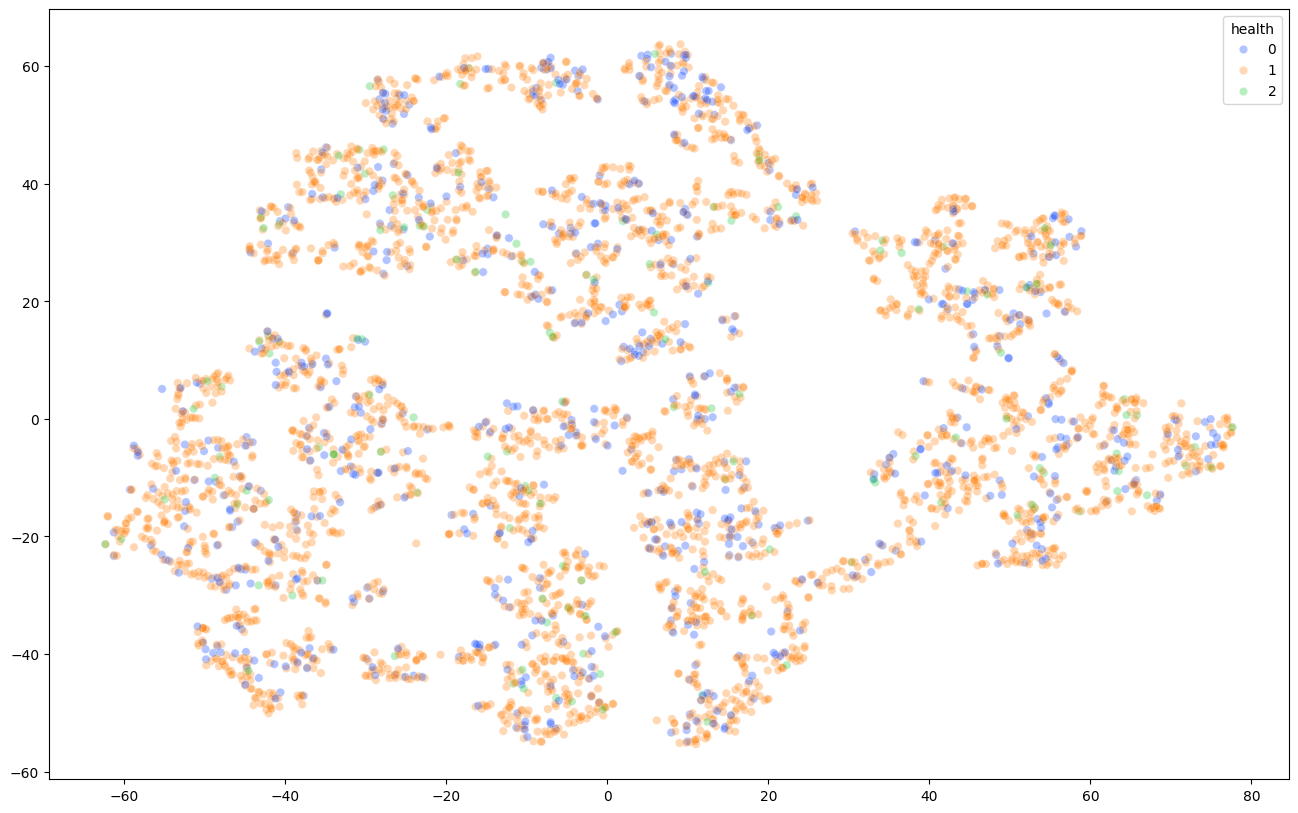

In [10]:
raw_tsne = TSNE(n_components=2, random_state=SEED)
tsne_raw_results = raw_tsne.fit_transform(x_valid)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_raw_results[:, 0], y=tsne_raw_results[:, 1],
    hue=y_valid,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()

# train model

In [11]:
def mean_f1score(preds:np.ndarray,eval_data: lgb.Dataset):
    y_true = eval_data.get_label()
    weight = eval_data.get_weight()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    f1 = f1_score(y_true,preds,average='macro',sample_weight=weight)
    return 'f1',f1,True

In [12]:
lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced',y=y_train))

params = {
    'objective': 'multiclass',
    'metric': None,
    'num_class': 3,
    'seed': 42,
    'num_threads': -1,
}
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train],
    valid_names=['train'],
    num_boost_round=1000,
    # early_stopping_rounds=100,
    # verbose_eval=100,
    feval=mean_f1score,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        # lgb.reset_parameter(learning_rate=lambda current_round: 0.01 * 0.995 ** current_round),
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 37
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


# evaluate model

In [13]:
valid_probs = model.predict(x_valid)

In [14]:
pred_valid = pd.DataFrame(valid_probs.argmax(axis=1), columns=["health"], index=x_valid.index)
f1_score(y_valid, pred_valid, average="macro")

0.33747561734454296

# maximize score

In [15]:
# this model's maximize f1 score
def sort_predict(model, x, ratios=[0.176, 0.788, 0.035]):
    pred = model.predict(x)
    pred = pd.DataFrame(pred, columns=["good", "normal", "bad"], index=x.index)
    good_count = int(len(x)*ratios[0])
    # normal_count = int(len(x)*ratios[1])
    bad_count = int(len(x)*ratios[2])
    pred_sortbybad = pred.sort_values(by="bad", ascending=False)
    # pred_sortbynormal = pred.sort_values(by="normal", ascending=False)
    pred_sortbygood = pred.sort_values(by="good", ascending=False)
    pred["health"] = 1
    pred.loc[pred_sortbybad.iloc[:bad_count, :].index, "health"] = 2
    pred.loc[pred_sortbygood.iloc[:good_count, :].index, "health"] = 0
    return pred["health"]

ratio = train["health"].value_counts(normalize=True).sort_index()
f1_score(y_valid, sort_predict(model, x_valid, ratio), average="macro")

0.3457213198021423

In [16]:
pred_valid.value_counts()/len(pred_valid)

health
1         0.870403
0         0.121091
2         0.008506
Name: count, dtype: float64

# evaluate model

In [64]:
valid_probs_df = pd.DataFrame(valid_probs, columns=["good", "normal", "bad"], index=x_valid.index)
valid_probs_df["predict_probability"] = valid_probs_df.max(axis=1)
valid_probs_df["predict_label"] = valid_probs_df.idxmax(axis=1)
valid_probs_df["true_label"] = y_valid.map({0: "good", 1: "normal", 2: "bad"})
valid_probs_df

,good,normal,bad,predict_probability,predict_label,true_label
14501,0.709521,0.274172,0.016308,0.709521,good,good
11864,0.788781,0.182158,0.029061,0.788781,good,bad
4283,0.275287,0.705459,0.019255,0.705459,normal,normal
2723,0.281823,0.717988,0.000189,0.717988,normal,good
13136,0.177930,0.819654,0.002416,0.819654,normal,normal
...,...,...,...,...,...,...
12162,0.762946,0.236793,0.000261,0.762946,good,normal
17006,0.141454,0.858526,0.000021,0.858526,normal,normal
8532,0.165492,0.829426,0.005082,0.829426,normal,normal
10537,0.424826,0.570374,0.004801,0.570374,normal,normal


## distribution of probabilities

<Axes: ylabel='Frequency'>

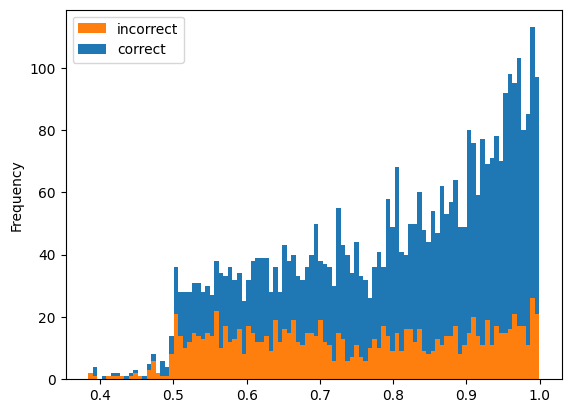

In [68]:
df = valid_probs_df.copy()
correct_color, incorrect_color = "tab:blue", "tab:orange"
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True,color=[incorrect_color, correct_color])
plt.title('Prediction probabilities(all)')

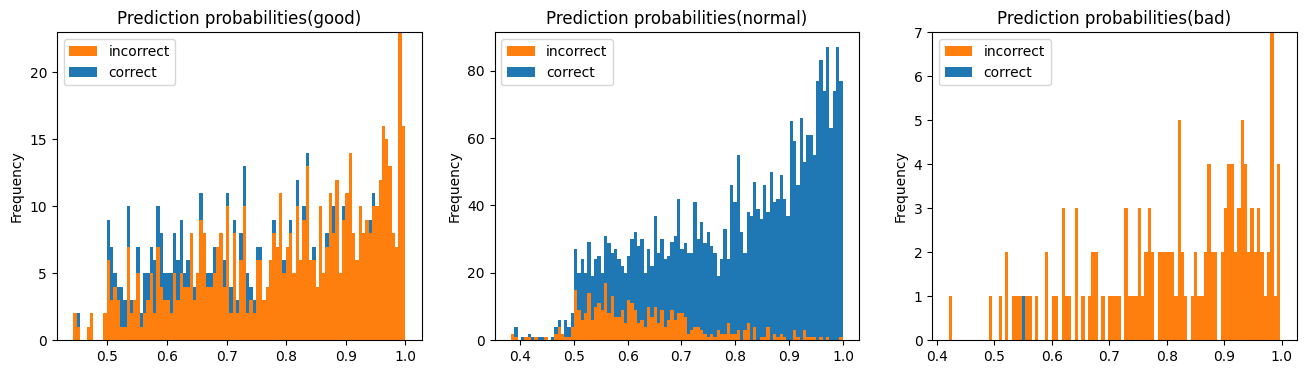

In [79]:
label_list = ["good", "normal", "bad"]
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for label in label_list:
    df = valid_probs_df.loc[valid_probs_df.true_label==label,:].copy()
    correct_color, incorrect_color = "tab:blue", "tab:orange"
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True,color=[incorrect_color, correct_color], ax=axes[label_list.index(label)])
    axes[label_list.index(label)].set_title(f'Prediction probabilities({label})')
plt.show()

## histogram of probabilities

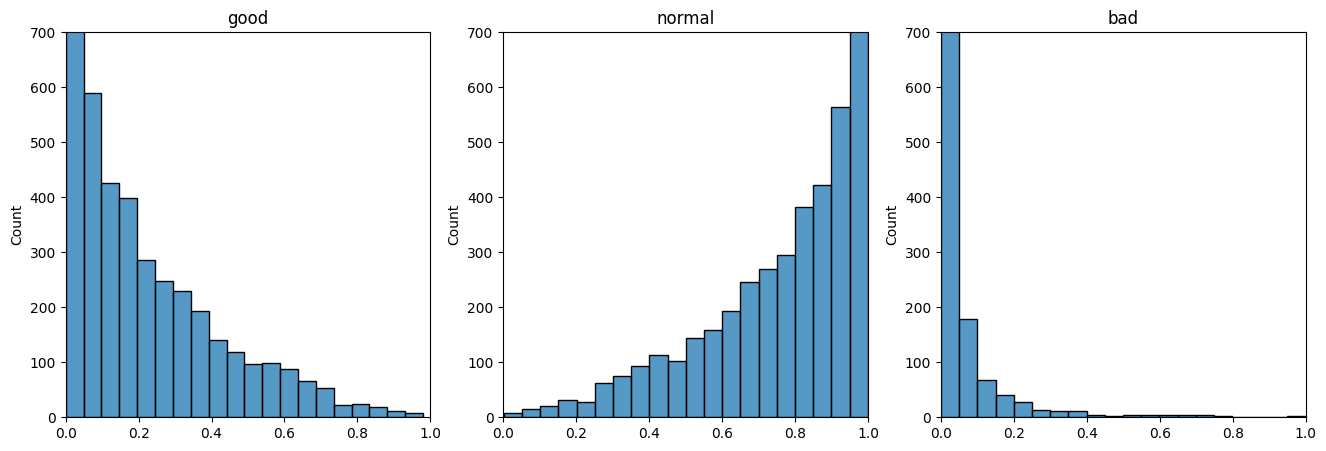

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ymax = 700
bins = 20
sns.histplot(valid_probs[:, 0], ax=axes[0], bins=bins)
axes[0].set_title("good")
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, ymax])
sns.histplot(valid_probs[:, 1], ax=axes[1], bins=bins)
axes[1].set_title("normal")
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, ymax])
sns.histplot(valid_probs[:, 2], ax=axes[2], bins=bins)
axes[2].set_title("bad")
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, ymax])
plt.show()

## scatter plot of probabilities

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


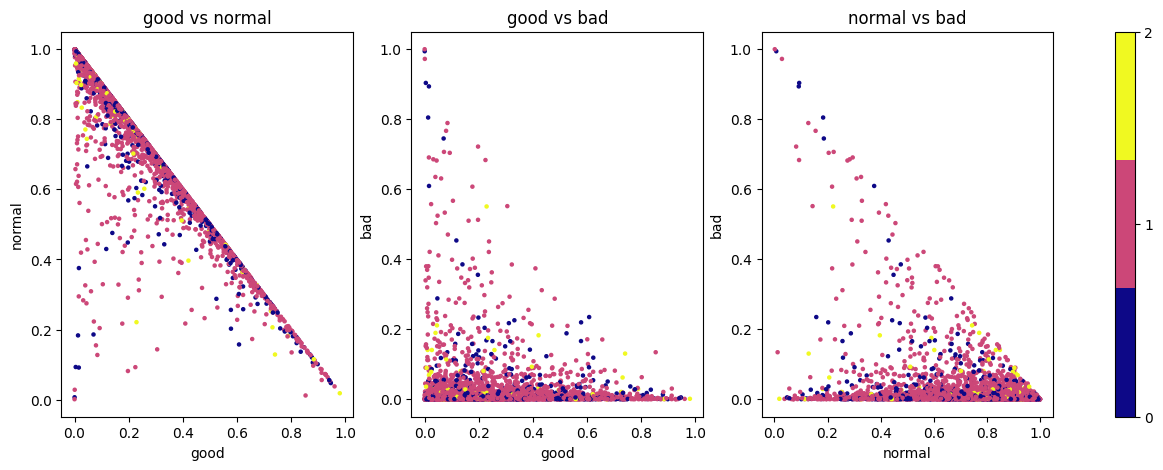

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
cmap_name = "plasma"
cmap = plt.cm.get_cmap(cmap_name, 3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
fig.colorbar(sm, ax=axes, ticks=[0, 1, 2])

axes[0].scatter(valid_probs[:, 0], valid_probs[:, 1], c=y_valid, s=5, cmap=cmap_name)
axes[0].set_xlabel("good")
axes[0].set_ylabel("normal")
axes[0].set_title("good vs normal")

axes[1].scatter(valid_probs[:, 0], valid_probs[:, 2], c=y_valid, s=5, cmap=cmap_name)
axes[1].set_xlabel("good")
axes[1].set_ylabel("bad")
axes[1].set_title("good vs bad")

axes[2].scatter(valid_probs[:, 1], valid_probs[:, 2], c=y_valid, s=5, cmap=cmap_name)
axes[2].set_xlabel("normal")
axes[2].set_ylabel("bad")
axes[2].set_title("normal vs bad")
plt.show()

## t-SNE plot

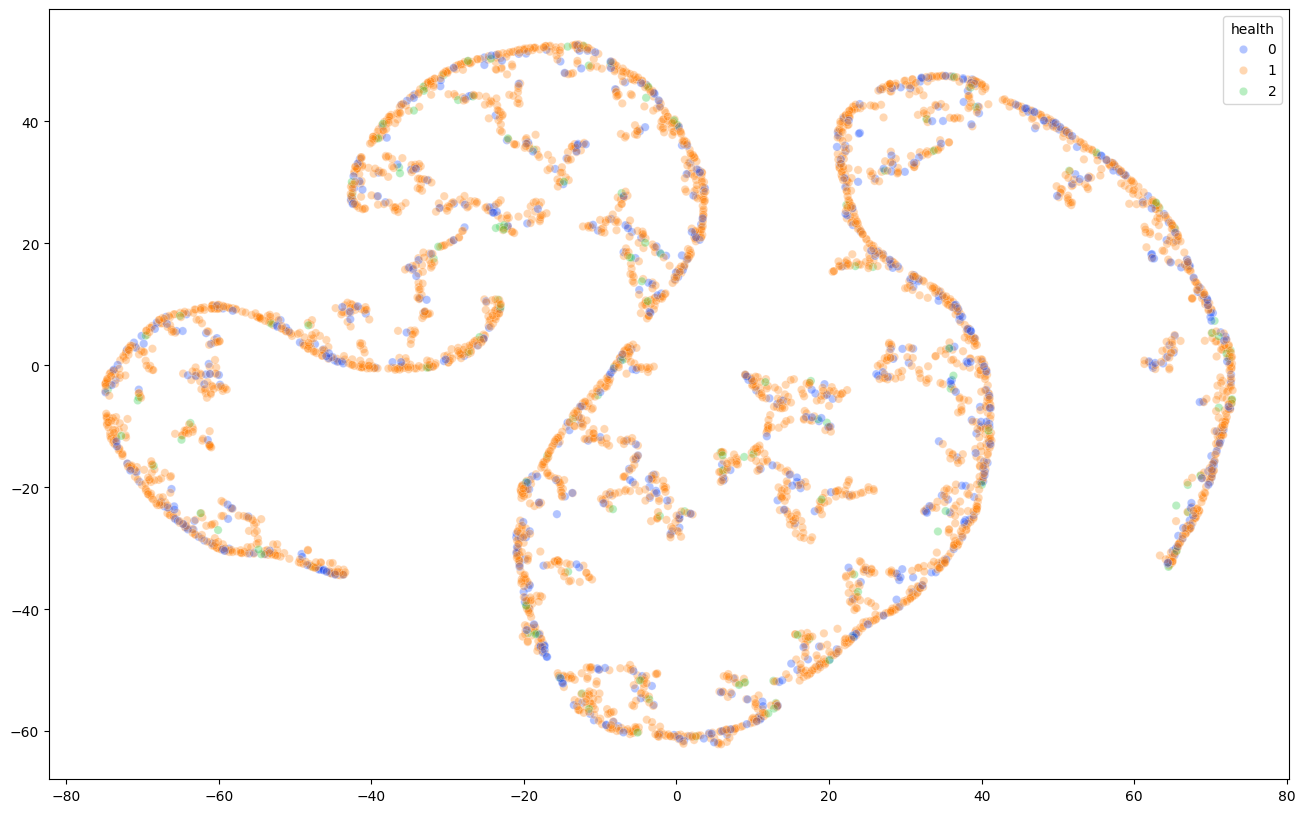

In [20]:
tsne = TSNE(n_components=2, random_state=SEED)
tsne_trained_results = tsne.fit_transform(model.predict(x_valid))
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_trained_results[:, 0], y=tsne_trained_results[:, 1],
    hue=y_valid,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

## importances of features

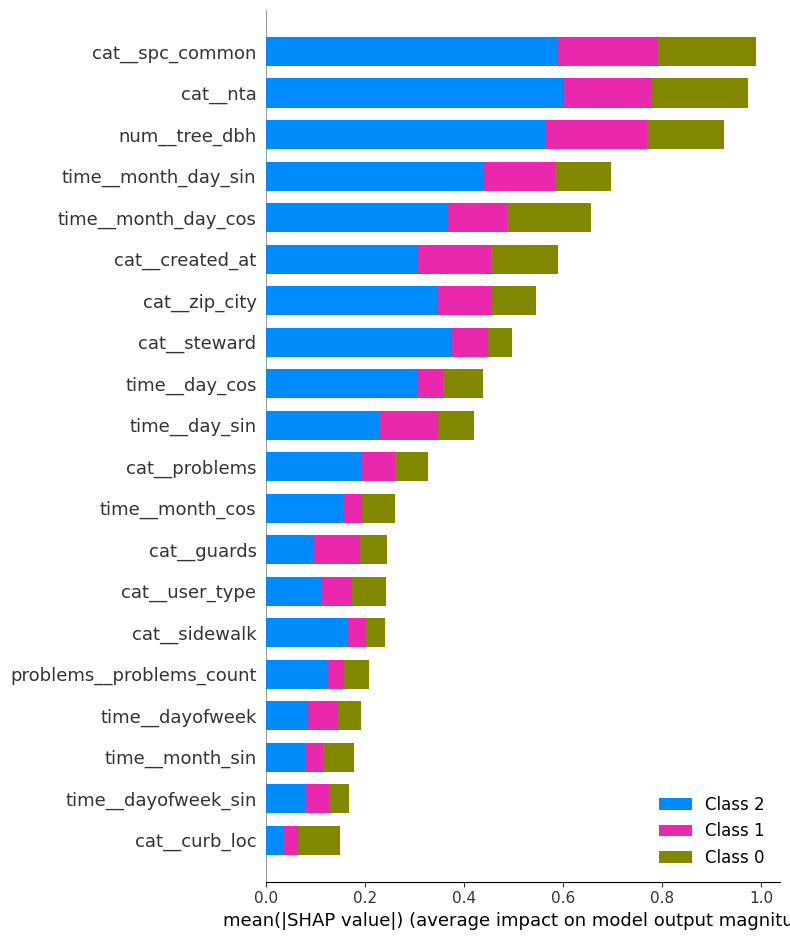

In [22]:
shap.summary_plot(shap_values, x_valid, plot_type="bar")

## make submission

In [23]:
submit_name = "lgbm"
predict = pd.DataFrame(model.predict(x_test).argmax(axis=1), columns=["health"], index=x_test.index)
predict.to_csv(f"submission/{submit_name}_submission.csv",  header=False)
# model.booster_.save_model(f"model/{submit_name}_model.pt")